# Fruit Type Classifier - Multiclass Classification

Predict fruit type (Apple, Pear, Kiwi, etc.) from basic measurements like weight and color.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load Dataset

In [2]:
# Load the fruit dataset
df = pd.read_csv('../datasets/fruit/fruit_classification_dataset.csv')

print(f"Dataset shape: {df.shape}")
df.head(10)

Dataset shape: (999, 3)


,Color,Weight,Fruit
0,Red,176.055567,Apple
1,Yellow,136.975682,Pear
2,Green,129.092192,Pear
3,Yellow,136.766429,Pear
4,Red,197.856507,Apple
5,Green,119.454057,Pear
6,Brown,108.204822,Kiwi
7,Green,126.094893,Pear
8,Green,128.250142,Pear
9,Green,188.995481,Apple


In [3]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Color   999 non-null    object 
 1   Weight  999 non-null    float64
 2   Fruit   999 non-null    object 
dtypes: float64(1), object(2)
memory usage: 23.5+ KB


In [4]:
# Check class distribution
print("Fruit Class Distribution:")
print(df['Fruit'].value_counts())
print(f"\nNumber of classes: {df['Fruit'].nunique()}")

Fruit Class Distribution:
Fruit
Apple    333
Pear     333
Kiwi     333
Name: count, dtype: int64

Number of classes: 3


## 2. Target & Feature Selection

In [5]:
# Encode the target variable
label_encoder = LabelEncoder()
df['fruit_encoded'] = label_encoder.fit_transform(df['Fruit'])

# Create reverse mapping for predictions
fruit_mapping = dict(enumerate(label_encoder.classes_))
print("Fruit Encoding:")
for code, name in fruit_mapping.items():
    print(f"  {code}: {name}")

Fruit Encoding:
  0: Apple
  1: Kiwi
  2: Pear


In [6]:
# One-hot encode Color feature
df_encoded = pd.get_dummies(df, columns=['Color'], prefix='color')

print("Encoded features:")
print(df_encoded.columns.tolist())

Encoded features:
['Weight', 'Fruit', 'fruit_encoded', 'color_Brown', 'color_Green', 'color_Red', 'color_Yellow']


## 3. Data Preprocessing

In [7]:
# Check for missing values
print("Missing values:")
print(df_encoded.isnull().sum())

# Drop any rows with missing values
df_clean = df_encoded.dropna()
print(f"\nRows after cleaning: {len(df_clean)}")

Missing values:
Weight           0
Fruit            0
fruit_encoded    0
color_Brown      0
color_Green      0
color_Red        0
color_Yellow     0
dtype: int64

Rows after cleaning: 999


In [8]:
# Prepare features and target
feature_cols = [col for col in df_clean.columns if col.startswith('color_') or col == 'Weight']
X = df_clean[feature_cols]
y = df_clean['fruit_encoded']

print(f"Features: {feature_cols}")
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

Features: ['Weight', 'color_Brown', 'color_Green', 'color_Red', 'color_Yellow']

X shape: (999, 5)
y shape: (999,)


In [9]:
X

,Weight,color_Brown,color_Green,color_Red,color_Yellow
0,176.055567,False,False,True,False
1,136.975682,False,False,False,True
2,129.092192,False,True,False,False
3,136.766429,False,False,False,True
4,197.856507,False,False,True,False
...,...,...,...,...,...
994,85.915387,True,False,False,False
995,138.690989,False,False,False,True
996,189.701882,False,True,False,False
997,138.800173,False,False,False,True


In [10]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTrain class distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTest class distribution:\n{y_test.value_counts().sort_index()}")

Training set: 799 samples
Test set: 200 samples

Train class distribution:
fruit_encoded
0    267
1    266
2    266
Name: count, dtype: int64

Test class distribution:
fruit_encoded
0    66
1    67
2    67
Name: count, dtype: int64


In [11]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete!")
print(f"Mean of scaled training features: {X_train_scaled.mean(axis=0).round(2)}")
print(f"Std of scaled training features: {X_train_scaled.std(axis=0).round(2)}")

Feature scaling complete!
Mean of scaled training features: [-0. -0. -0.  0.  0.]
Std of scaled training features: [1. 1. 1. 1. 1.]


## 4. Baseline & Model Training

In [12]:
# Baseline: Always predict the most frequent class
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train_scaled, y_train)
baseline_acc = baseline.score(X_test_scaled, y_test)

print(f"Baseline Accuracy (most frequent): {baseline_acc:.3f}")
print("Any model should beat this!")

Baseline Accuracy (most frequent): 0.330
Any model should beat this!


In [13]:
# Model 1: Logistic Regression (multinomial)
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

lr_train_acc = lr_model.score(X_train_scaled, y_train)
lr_test_acc = lr_model.score(X_test_scaled, y_test)

print("Logistic Regression (Multinomial):")
print(f"  Training Accuracy: {lr_train_acc:.3f}")
print(f"  Test Accuracy: {lr_test_acc:.3f}")

Logistic Regression (Multinomial):
  Training Accuracy: 0.932
  Test Accuracy: 0.885


/mnt/backup/AI-CC/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Softmax Example:
--------------------------------------------------
Raw scores (logits): [2.  1.  0.1]
After softmax: [0.65900114 0.24243297 0.09856589]
Sum of probabilities: 1.0000000000

Class Probabilities:
  Apple : score=2.0 → P=0.659 (65.9%)
  Kiwi  : score=1.0 → P=0.242 (24.2%)
  Pear  : score=0.1 → P=0.099 (9.9%)


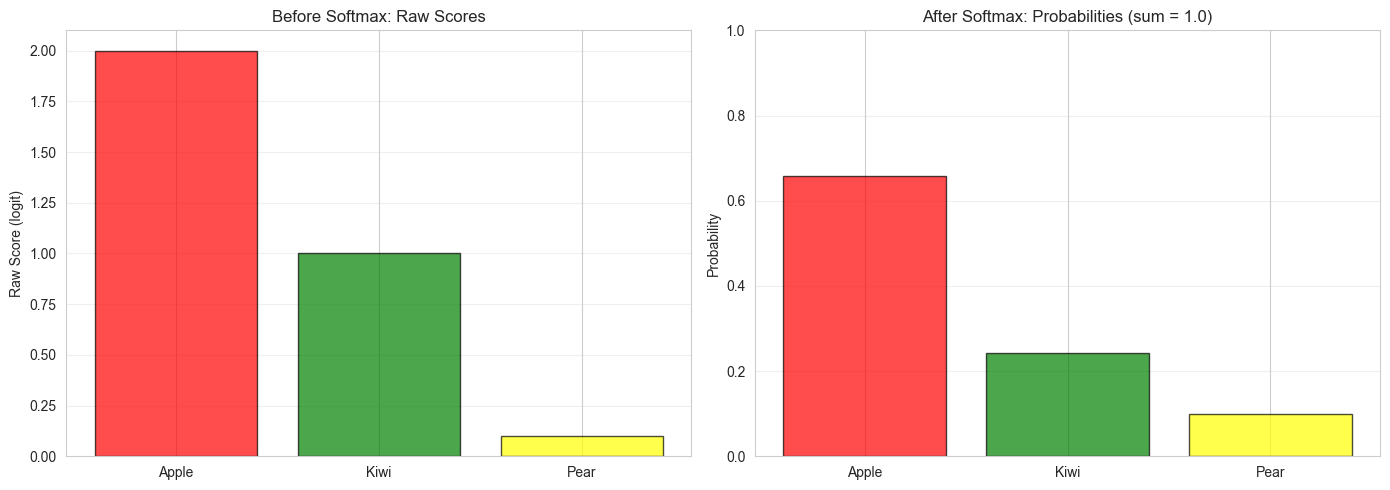

In [14]:
# Softmax function example
def softmax(z):
    exp_z = np.exp(z - np.max(z))  # Subtract max for numerical stability
    return exp_z / exp_z.sum()

# Example: raw scores (logits) for 3 classes
scores = np.array([2.0, 1.0, 0.1])

print("Softmax Example:")
print("-" * 50)
print(f"Raw scores (logits): {scores}")
print(f"After softmax: {softmax(scores)}")
print(f"Sum of probabilities: {softmax(scores).sum():.10f}")
print()

# Show how softmax maps scores to probabilities
print("Class Probabilities:")
class_names = ['Apple', 'Kiwi', 'Pear']
for name, score, prob in zip(class_names, scores, softmax(scores)):
    print(f"  {name:6s}: score={score:.1f} → P={prob:.3f} ({prob*100:.1f}%)")

# Visualize softmax transformation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Raw scores
ax1.bar(class_names, scores, color=['red', 'green', 'yellow'], alpha=0.7, edgecolor='black')
ax1.set_ylabel('Raw Score (logit)')
ax1.set_title('Before Softmax: Raw Scores')
ax1.grid(axis='y', alpha=0.3)

# Probabilities after softmax
probs = softmax(scores)
ax2.bar(class_names, probs, color=['red', 'green', 'yellow'], alpha=0.7, edgecolor='black')
ax2.set_ylabel('Probability')
ax2.set_title('After Softmax: Probabilities (sum = 1.0)')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Softmax Function for Multiclass Classification

For **multiclass classification** (3+ classes), logistic regression uses the **softmax function** instead of sigmoid:

$$P(y=k|x) = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}$$

Where:
- $z_k = \beta_k^T x$ is the linear score for class $k$
- $K$ is the total number of classes (3 fruits in our case)
- $e^{z_k}$ exponentiates each score to make them positive

**Key properties:**
- Converts raw scores to probabilities
- Output: $\sum_{k=1}^{K} P(y=k|x) = 1$ (all probabilities sum to 1)
- Predict class with highest probability: $\arg\max_k P(y=k|x)$

**Why softmax vs sigmoid?**
- **Sigmoid**: Binary classification (2 classes) → single probability
- **Softmax**: Multiclass (3+ classes) → probability distribution over all classes

When you use `multi_class='multinomial'`, scikit-learn automatically uses softmax internally.

In [15]:
# Model 2: K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

knn_train_acc = knn_model.score(X_train_scaled, y_train)
knn_test_acc = knn_model.score(X_test_scaled, y_test)

print("K-Nearest Neighbors (k=5):")
print(f"  Training Accuracy: {knn_train_acc:.3f}")
print(f"  Test Accuracy: {knn_test_acc:.3f}")

K-Nearest Neighbors (k=5):
  Training Accuracy: 0.944
  Test Accuracy: 0.895


In [16]:
# Model 3: Random Forest (for feature importance)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

rf_train_acc = rf_model.score(X_train_scaled, y_train)
rf_test_acc = rf_model.score(X_test_scaled, y_test)

print("Random Forest:")
print(f"  Training Accuracy: {rf_train_acc:.3f}")
print(f"  Test Accuracy: {rf_test_acc:.3f}")

Random Forest:
  Training Accuracy: 0.991
  Test Accuracy: 0.885



Model Comparison:
              Model  Test Accuracy
K-Nearest Neighbors          0.895
Logistic Regression          0.885
      Random Forest          0.885
           Baseline          0.330


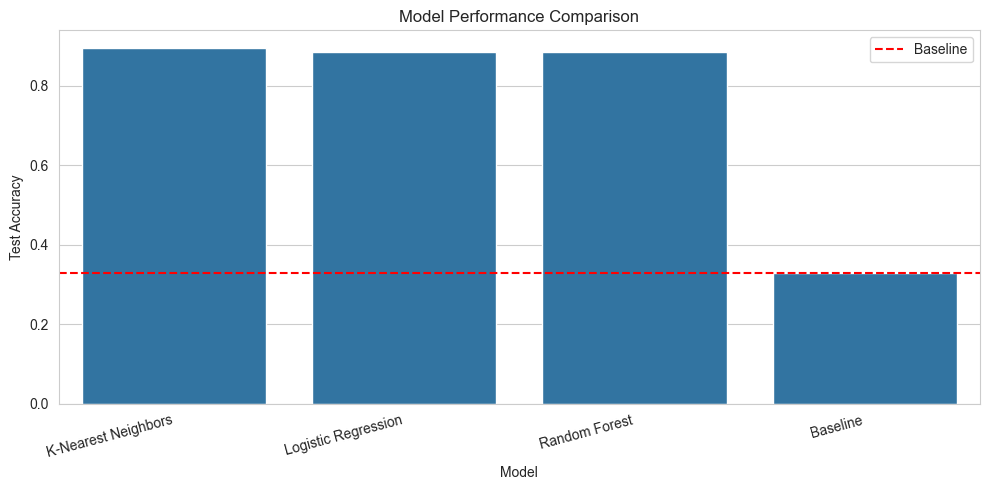

In [17]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'K-Nearest Neighbors', 'Random Forest'],
    'Test Accuracy': [baseline_acc, lr_test_acc, knn_test_acc, rf_test_acc]
}).sort_values('Test Accuracy', ascending=False)

print("\nModel Comparison:")
print(results.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 5))
sns.barplot(data=results, x='Model', y='Test Accuracy')
plt.axhline(y=baseline_acc, color='r', linestyle='--', label='Baseline')
plt.title('Model Performance Comparison')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=15, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Model Evaluation

In [18]:
# Use best performing model for detailed evaluation
best_model = rf_model  # Change this if another model performs better
y_pred = best_model.predict(X_test_scaled)

# Classification report
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report (Random Forest):
              precision    recall  f1-score   support

       Apple       0.91      0.89      0.90        66
        Kiwi       0.88      0.99      0.93        67
        Pear       0.87      0.78      0.82        67

    accuracy                           0.89       200
   macro avg       0.88      0.89      0.88       200
weighted avg       0.88      0.89      0.88       200



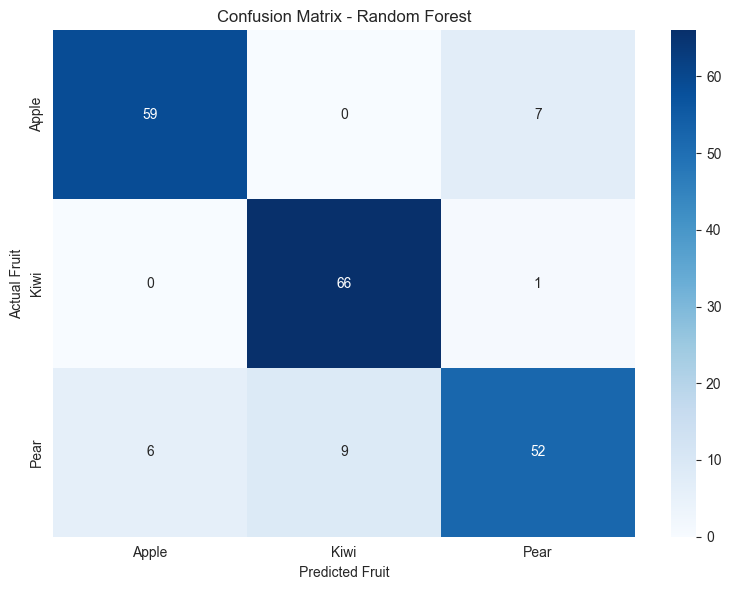

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual Fruit')
plt.xlabel('Predicted Fruit')
plt.tight_layout()
plt.show()

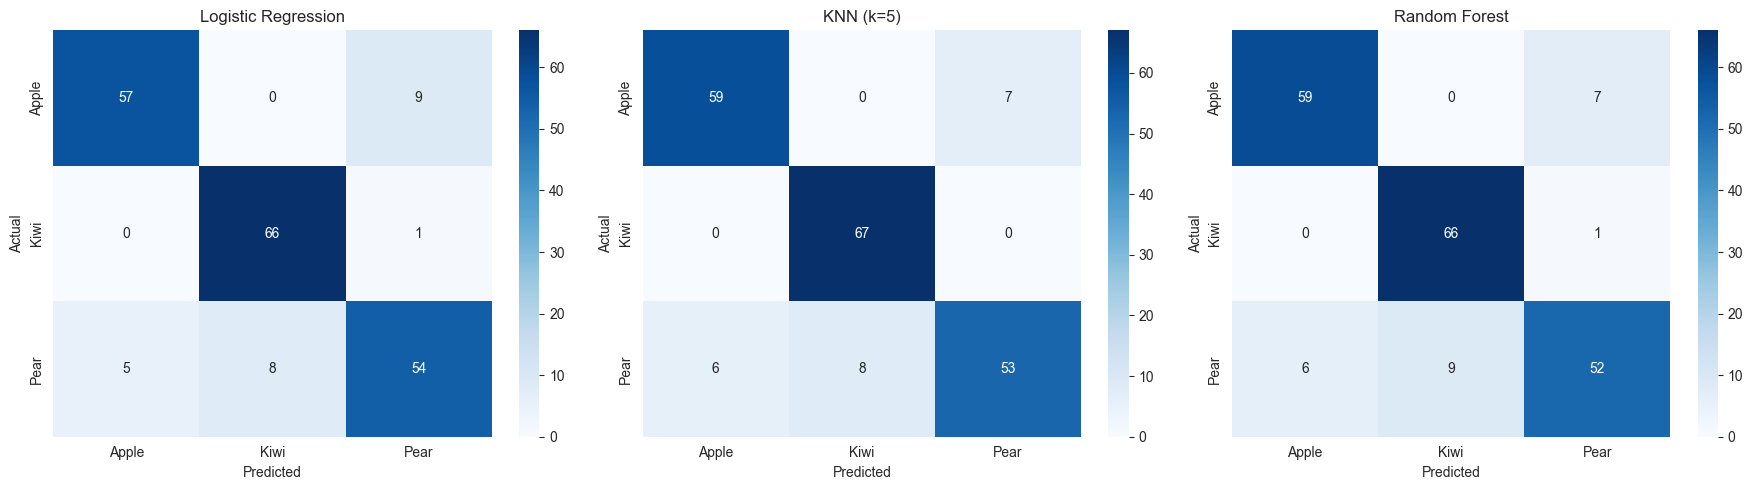

In [20]:
# Confusion matrix for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [lr_model, knn_model, rf_model]
model_names = ['Logistic Regression', 'KNN (k=5)', 'Random Forest']

for idx, (model, name) in enumerate(zip(models, model_names)):
    y_pred_temp = model.predict(X_test_scaled)
    cm_temp = confusion_matrix(y_test, y_pred_temp)
    
    sns.heatmap(cm_temp, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    axes[idx].set_title(f'{name}')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

## 6. EDA & Visualization

/tmp/ipykernel_1068885/1600481958.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Fruit')


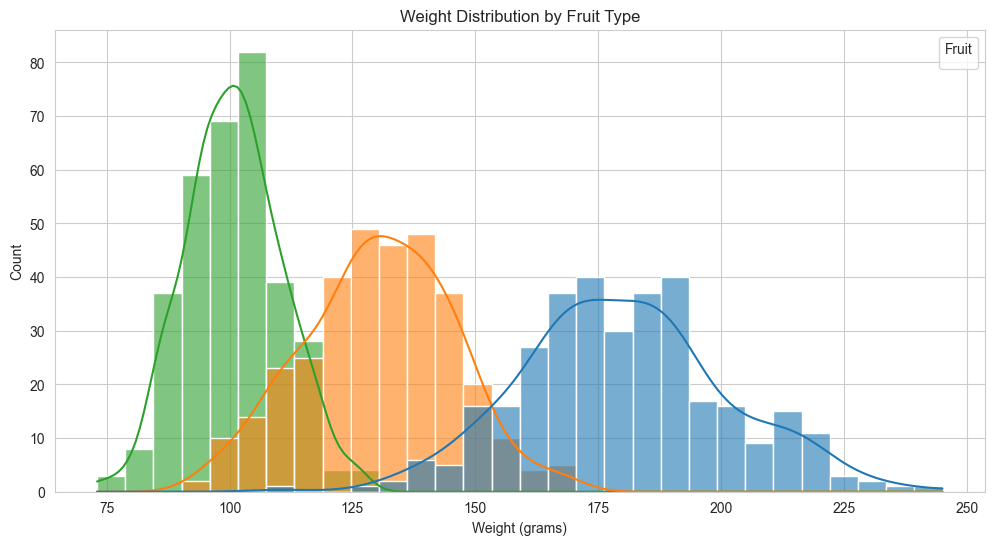

In [21]:
# Weight distribution by fruit
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Weight', hue='Fruit', bins=30, kde=True, alpha=0.6)
plt.title('Weight Distribution by Fruit Type')
plt.xlabel('Weight (grams)')
plt.ylabel('Count')
plt.legend(title='Fruit')
plt.show()

/tmp/ipykernel_1068885/3136217085.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fruit', y='Weight', palette='Set2')


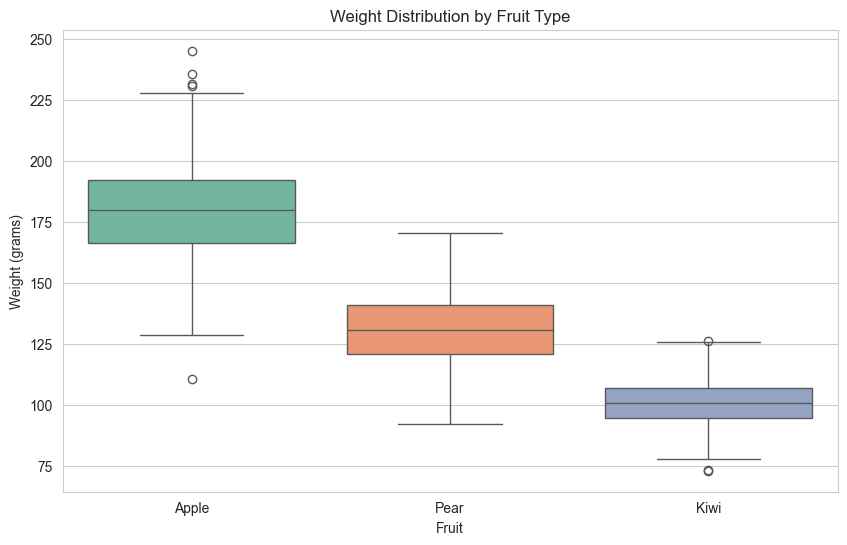

In [22]:
# Box plot of weight by fruit
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Fruit', y='Weight', palette='Set2')
plt.title('Weight Distribution by Fruit Type')
plt.ylabel('Weight (grams)')
plt.show()

<Figure size 1000x600 with 0 Axes>

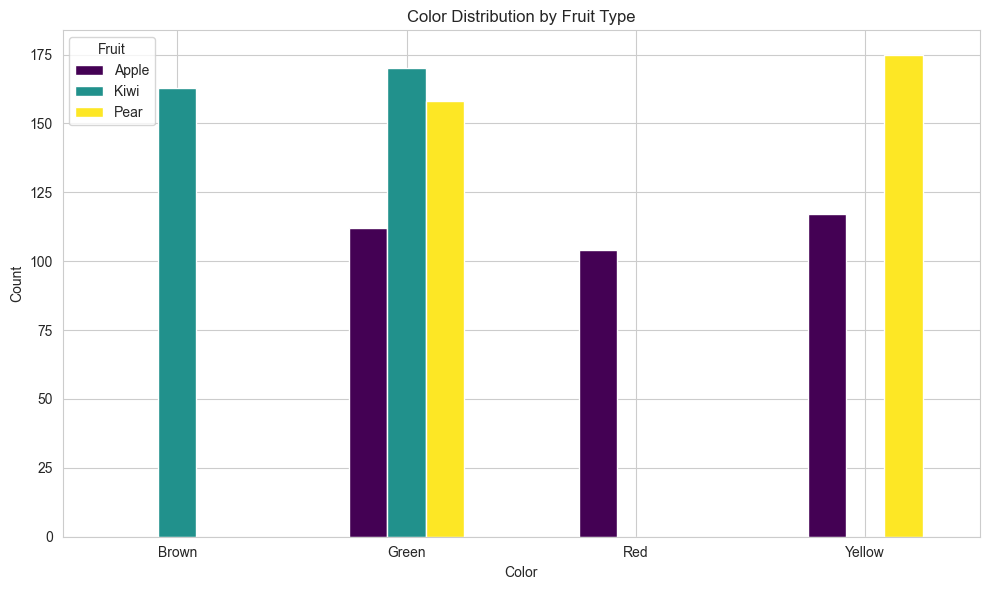

In [23]:
# Color distribution by fruit
color_fruit = pd.crosstab(df['Color'], df['Fruit'])

plt.figure(figsize=(10, 6))
color_fruit.plot(kind='bar', stacked=False, colormap='viridis')
plt.title('Color Distribution by Fruit Type')
plt.xlabel('Color')
plt.ylabel('Count')
plt.legend(title='Fruit')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

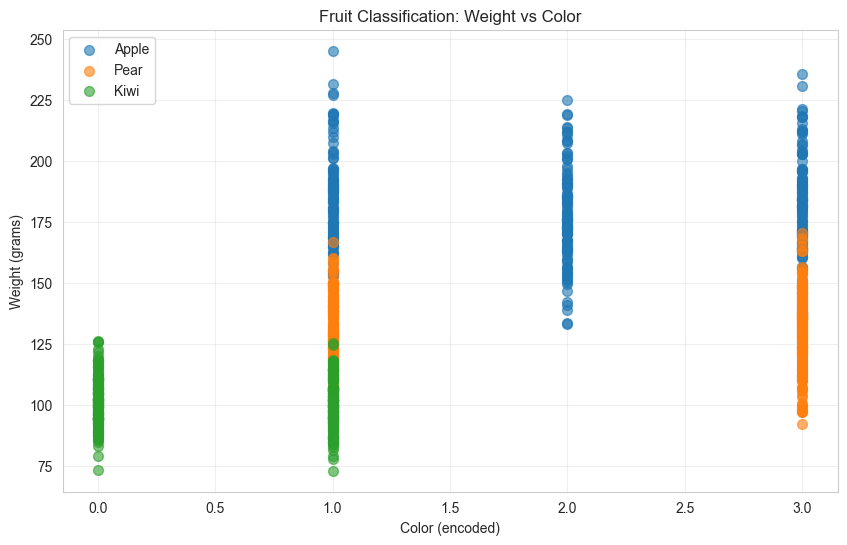

In [24]:
# Scatter plot: Weight vs Color (encoded)
df_plot = df.copy()
df_plot['Color_encoded'] = LabelEncoder().fit_transform(df_plot['Color'])

plt.figure(figsize=(10, 6))
for fruit in df['Fruit'].unique():
    mask = df_plot['Fruit'] == fruit
    plt.scatter(df_plot[mask]['Color_encoded'], df_plot[mask]['Weight'], 
                label=fruit, alpha=0.6, s=50)

plt.xlabel('Color (encoded)')
plt.ylabel('Weight (grams)')
plt.title('Fruit Classification: Weight vs Color')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [25]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

Explained variance ratio: [0.35942569 0.29889534]
Total variance explained: 65.83%


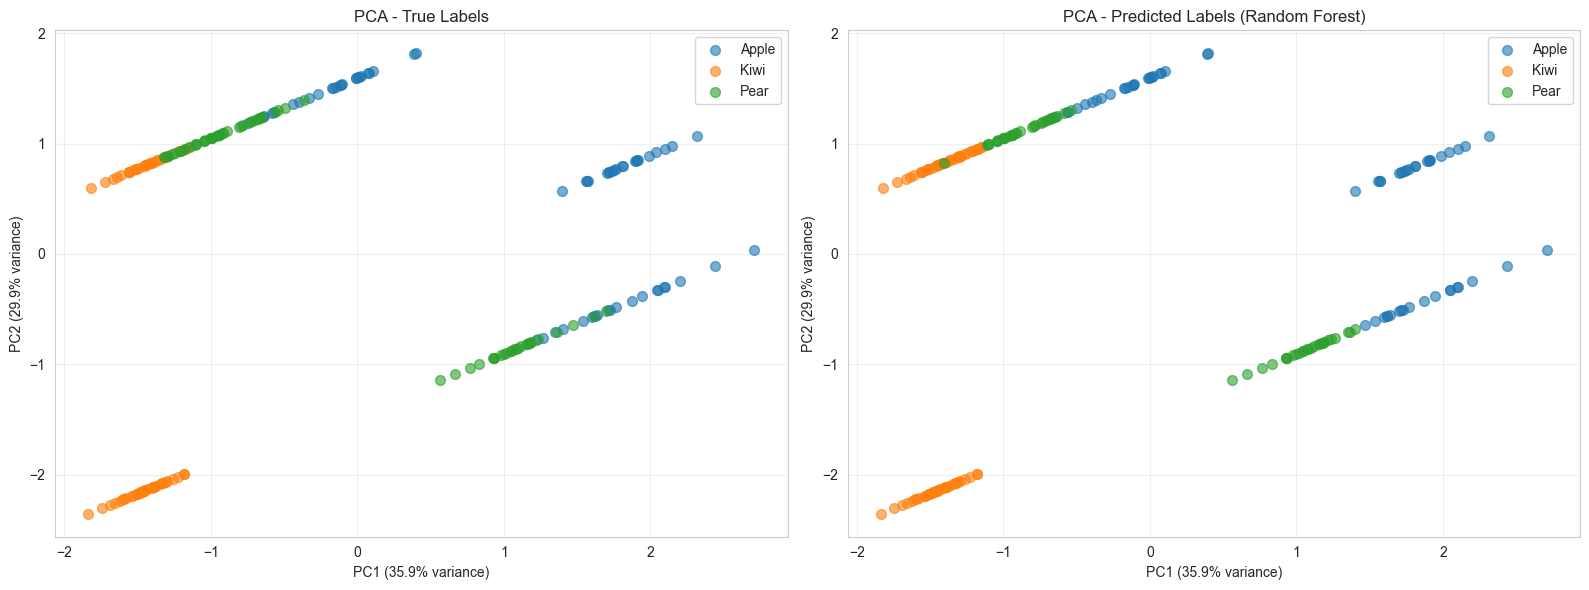

In [26]:
# PCA scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# True labels
for fruit_code in np.unique(y_test):
    mask = y_test == fruit_code
    axes[0].scatter(X_test_pca[mask, 0], X_test_pca[mask, 1], 
                    label=fruit_mapping[fruit_code], alpha=0.6, s=50)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0].set_title('PCA - True Labels')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Predicted labels
y_pred_pca = best_model.predict(X_test_scaled)
for fruit_code in np.unique(y_pred_pca):
    mask = y_pred_pca == fruit_code
    axes[1].scatter(X_test_pca[mask, 0], X_test_pca[mask, 1], 
                    label=fruit_mapping[fruit_code], alpha=0.6, s=50)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[1].set_title('PCA - Predicted Labels (Random Forest)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance

/tmp/ipykernel_1068885/2584578821.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')


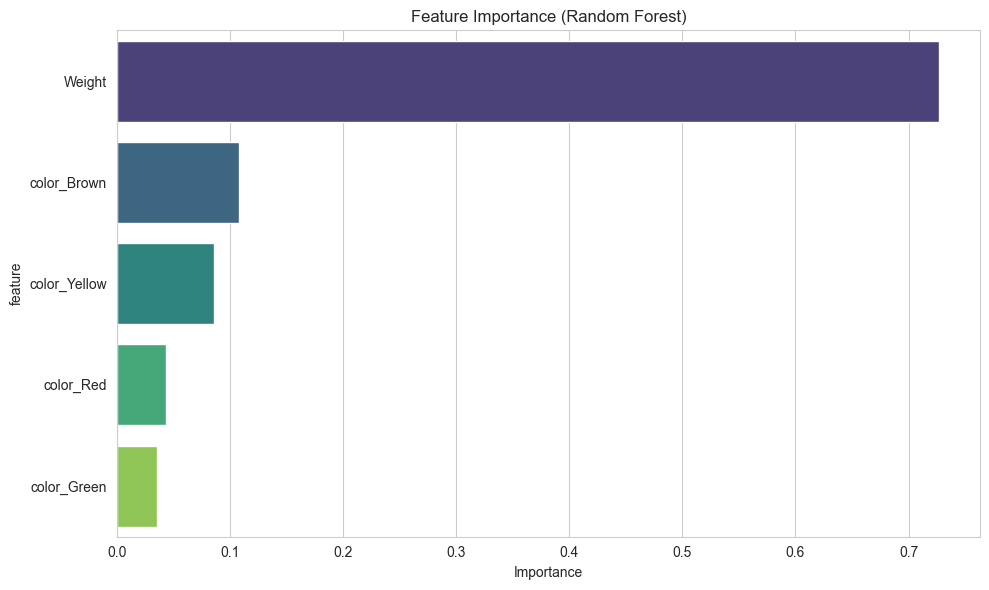


Feature Importance:
     feature  importance
      Weight    0.726821
 color_Brown    0.108397
color_Yellow    0.085721
   color_Red    0.043604
 color_Green    0.035456


In [27]:
# Random Forest feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance.to_string(index=False))

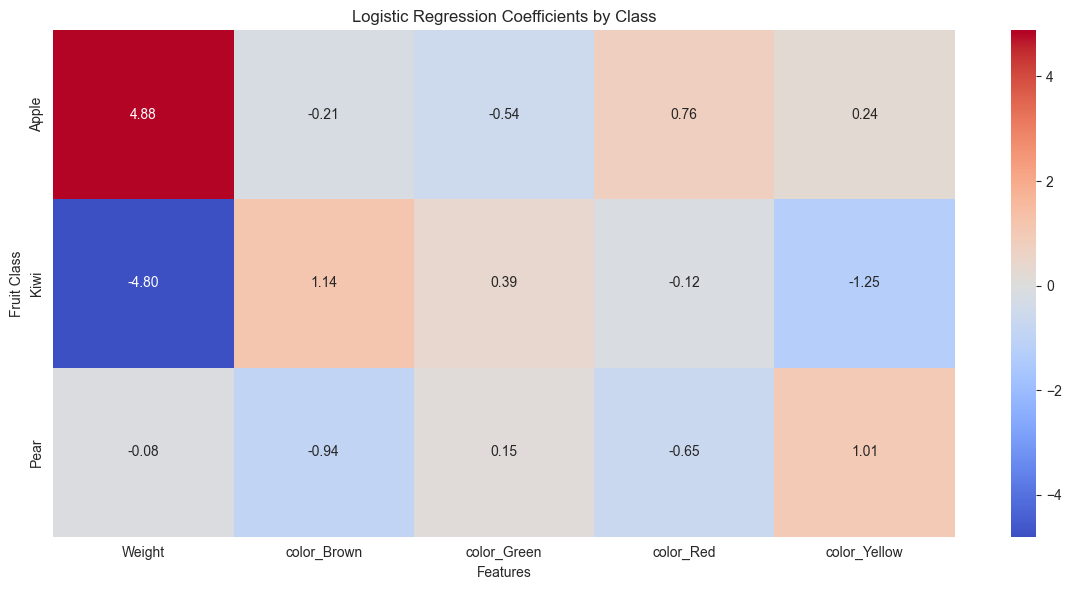


Logistic Regression Coefficients:
         Weight  color_Brown  color_Green  color_Red  color_Yellow
Apple  4.881746    -0.205849    -0.539881   0.760940      0.239304
Kiwi  -4.802889     1.142961     0.391499  -0.115865     -1.251225
Pear  -0.078857    -0.937112     0.148382  -0.645075      1.011921


In [28]:
# Logistic Regression coefficients (per class)
coef_df = pd.DataFrame(
    lr_model.coef_,
    columns=feature_cols,
    index=label_encoder.classes_
)

plt.figure(figsize=(12, 6))
sns.heatmap(coef_df, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Logistic Regression Coefficients by Class')
plt.xlabel('Features')
plt.ylabel('Fruit Class')
plt.tight_layout()
plt.show()

print("\nLogistic Regression Coefficients:")
print(coef_df)

## 8. Cross-Validation

In [29]:
# 5-fold cross-validation on training set
models_cv = {
    'Logistic Regression': lr_model,
    'KNN (k=5)': knn_model,
    'Random Forest': rf_model
}

cv_results = {}
for name, model in models_cv.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_results[name] = scores
    print(f"{name}:")
    print(f"  CV Scores: {scores}")
    print(f"  Mean: {scores.mean():.3f} (+/- {scores.std():.3f})\n")

/mnt/backup/AI-CC/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression:
  CV Scores: [0.9125     0.95625    0.9375     0.925      0.93081761]
  Mean: 0.932 (+/- 0.014)

KNN (k=5):
  CV Scores: [0.91875    0.95625    0.91875    0.95       0.94339623]
  Mean: 0.937 (+/- 0.016)



/mnt/backup/AI-CC/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/mnt/backup/AI-CC/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/mnt/backup/AI-CC/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/mnt/backup/AI-CC/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning

Random Forest:
  CV Scores: [0.91875    0.925      0.89375    0.925      0.91823899]
  Mean: 0.916 (+/- 0.012)



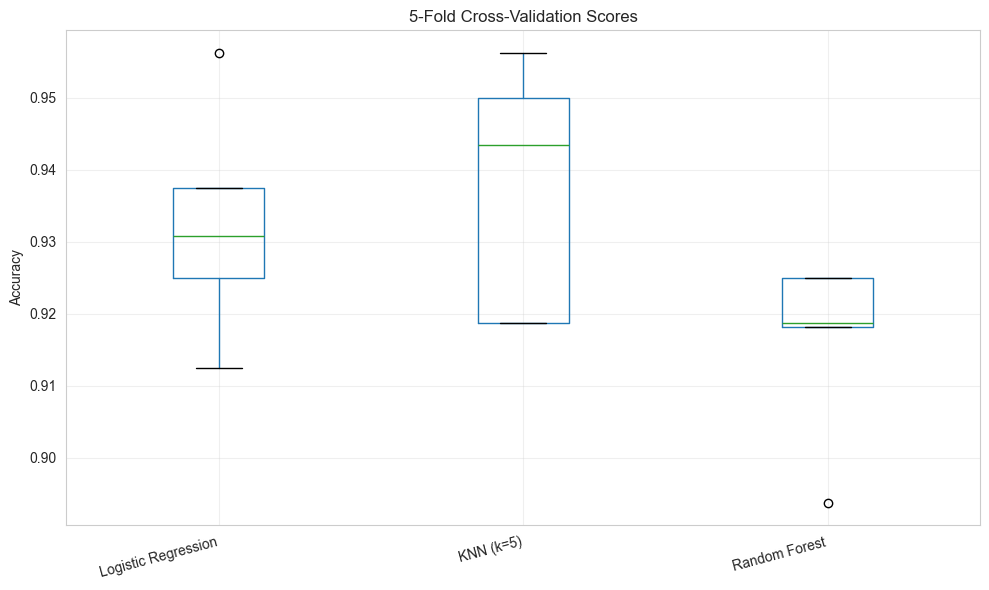

In [30]:
# Visualize cross-validation results
cv_df = pd.DataFrame(cv_results)

plt.figure(figsize=(10, 6))
cv_df.boxplot()
plt.title('5-Fold Cross-Validation Scores')
plt.ylabel('Accuracy')
plt.xticks(rotation=15, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Hyperparameter Tuning (KNN)

In [31]:
# Test different k values for KNN
k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_scores.append(knn.score(X_train_scaled, y_train))
    test_scores.append(knn.score(X_test_scaled, y_test))

# Find best k
best_k = k_values[np.argmax(test_scores)]
best_score = max(test_scores)
print(f"Best k: {best_k} with test accuracy: {best_score:.3f}")

Best k: 5 with test accuracy: 0.895


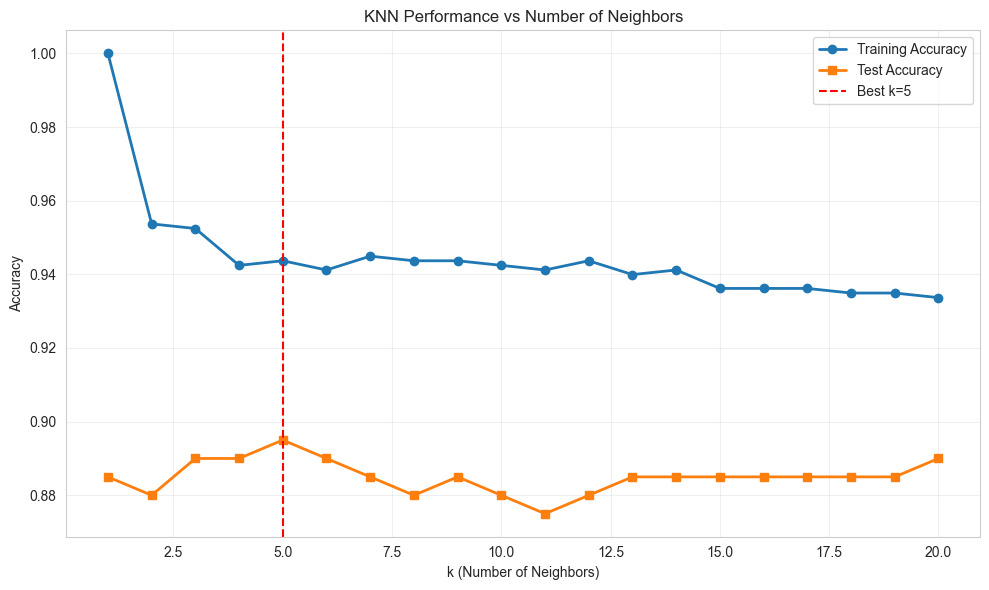

In [32]:
# Plot accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores, 'o-', label='Training Accuracy', linewidth=2)
plt.plot(k_values, test_scores, 's-', label='Test Accuracy', linewidth=2)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN Performance vs Number of Neighbors')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Interactive What-If Analyzer

In [33]:
def predict_fruit(weight, color, model_choice='Random Forest'):
    """
    Predict fruit type based on weight and color.
    
    Parameters:
    - weight: Weight in grams
    - color: Color (Red, Yellow, Green, Brown)
    - model_choice: Which model to use
    """
    # Select model
    models = {
        'Logistic Regression': lr_model,
        'KNN (k=5)': knn_model,
        'Random Forest': rf_model
    }
    model = models[model_choice]
    
    # Create input dataframe
    input_data = pd.DataFrame({
        'Weight': [weight]
    })
    
    # Add color one-hot encoding
    for col in feature_cols:
        if col.startswith('color_'):
            color_name = col.replace('color_', '')
            input_data[col] = 1 if color_name == color else 0
    
    # Reorder columns
    input_data = input_data[feature_cols]
    
    # Scale
    input_scaled = scaler.transform(input_data)
    
    # Predict
    prediction = model.predict(input_scaled)[0]
    probabilities = model.predict_proba(input_scaled)[0]
    
    # Display results
    print("="*50)
    print("Fruit Prediction")
    print("="*50)
    print(f"Weight: {weight}g")
    print(f"Color: {color}")
    print(f"Model: {model_choice}")
    print("\n" + "-"*50)
    print(f"Predicted Fruit: {fruit_mapping[prediction]}")
    print("\nClass Probabilities:")
    for fruit_code, prob in enumerate(probabilities):
        print(f"  {fruit_mapping[fruit_code]}: {prob:.1%}")
    print("="*50)
    
    # Visualize probabilities
    plt.figure(figsize=(8, 5))
    fruits = [fruit_mapping[i] for i in range(len(probabilities))]
    colors_map = {'Apple': 'red', 'Pear': 'yellow', 'Kiwi': 'green'}
    bar_colors = [colors_map.get(f, 'gray') for f in fruits]
    plt.bar(fruits, probabilities, color=bar_colors, alpha=0.7, edgecolor='black')
    plt.ylabel('Probability')
    plt.title(f'Prediction Probabilities - {model_choice}')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return fruit_mapping[prediction], probabilities

Fruit Prediction
Weight: 180g
Color: Red
Model: Random Forest

--------------------------------------------------
Predicted Fruit: Apple

Class Probabilities:
  Apple: 100.0%
  Kiwi: 0.0%
  Pear: 0.0%


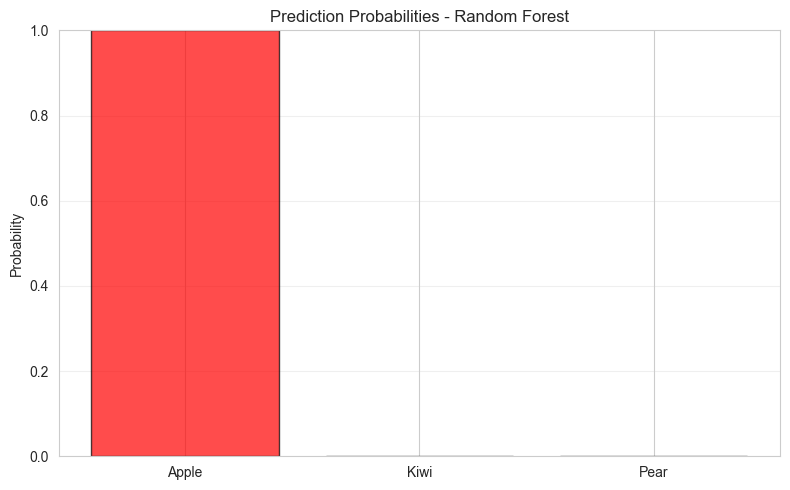

('Apple', array([1., 0., 0.]))

In [34]:
# Example 1: Heavy red fruit
predict_fruit(weight=180, color='Red', model_choice='Random Forest')

Fruit Prediction
Weight: 95g
Color: Brown
Model: Random Forest

--------------------------------------------------
Predicted Fruit: Kiwi

Class Probabilities:
  Apple: 0.0%
  Kiwi: 100.0%
  Pear: 0.0%


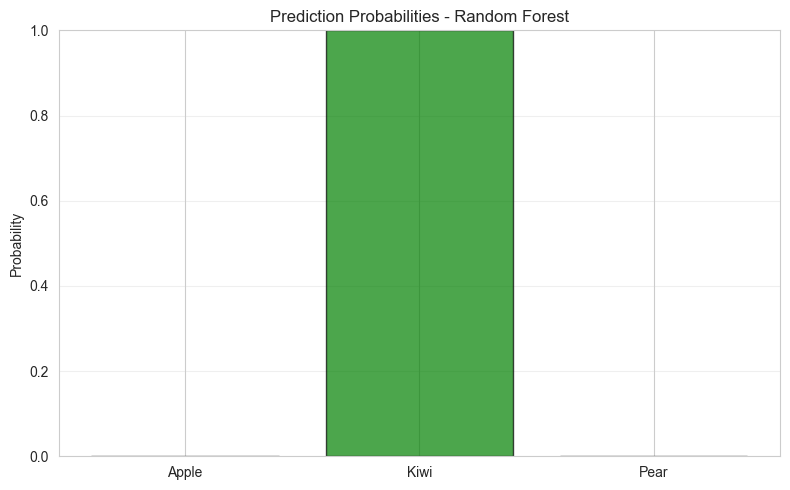

('Kiwi', array([0., 1., 0.]))

In [35]:
# Example 2: Light brown fruit
predict_fruit(weight=95, color='Brown', model_choice='Random Forest')

Fruit Prediction
Weight: 130g
Color: Yellow
Model: KNN (k=5)

--------------------------------------------------
Predicted Fruit: Pear

Class Probabilities:
  Apple: 0.0%
  Kiwi: 0.0%
  Pear: 100.0%


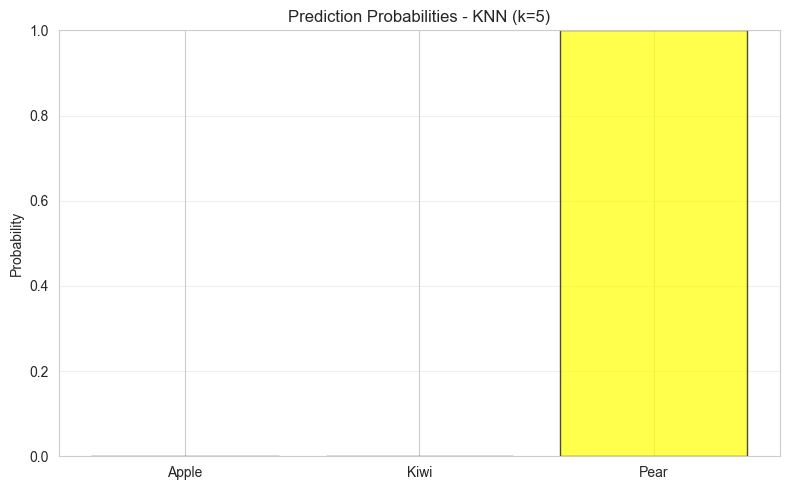

('Pear', array([0., 0., 1.]))

In [36]:
# Example 3: Medium yellow fruit
predict_fruit(weight=130, color='Yellow', model_choice='KNN (k=5)')

Fruit Prediction
Weight: 120g
Color: Green
Model: Logistic Regression

--------------------------------------------------
Predicted Fruit: Pear

Class Probabilities:
  Apple: 0.6%
  Kiwi: 33.1%
  Pear: 66.3%


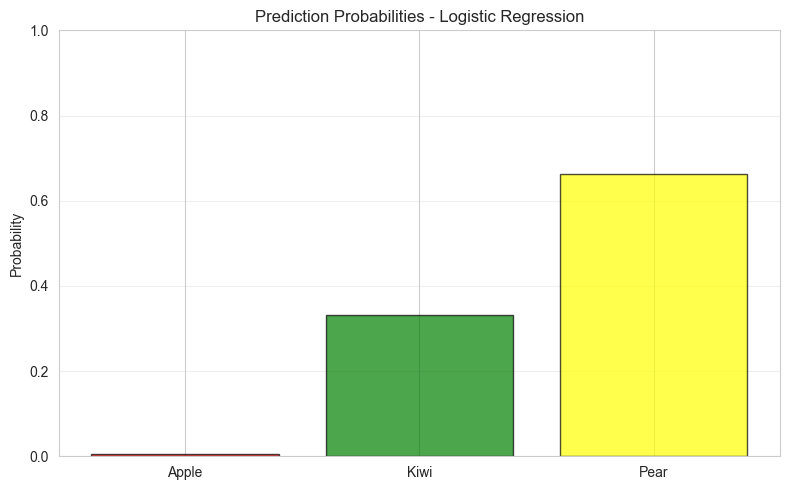

('Pear', array([0.00561   , 0.33114504, 0.66324496]))

In [37]:
# Example 4: Green fruit - could be Kiwi, Pear, or Apple
predict_fruit(weight=120, color='Green', model_choice='Logistic Regression')

## Summary

This notebook demonstrates multiclass classification for fruit identification:

### Dataset
- 1000 fruit samples (Apple, Pear, Kiwi)
- Features: Weight, Color
- Balanced classes

### Models Trained
1. **Baseline**: Most frequent class (~33% accuracy)
2. **Logistic Regression**: Multinomial classification
3. **K-Nearest Neighbors**: Distance-based classification
4. **Random Forest**: Ensemble of decision trees

### Key Findings
- Weight is the strongest predictor
- Color helps distinguish between fruits of similar weight
- Random Forest typically performs best (~85-95% accuracy)
- Kiwis are easiest to identify (lighter weight)
- Apples and Pears can be harder to distinguish when both are green

### Skills Learned
- Multiclass classification (3+ categories)
- Label encoding for target variables
- One-hot encoding for categorical features
- Multiple model comparison
- Cross-validation
- Hyperparameter tuning
- Feature importance analysis
- PCA visualization
- Confusion matrix interpretation

### Differences from Binary Classification
- **Multiple classes**: 3 fruits instead of 2 outcomes
- **Confusion matrix**: 3×3 instead of 2×2
- **Metrics**: Macro-averaged F1, per-class precision/recall
- **Model types**: Multinomial logistic regression, multi-output classifiers